# Noise Removing

In [1]:
import pydicom
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage
from skimage import morphology

In [2]:
file_path = "/Users/esmasert/Desktop/basicsDcm/10095.dcm"

In [3]:
medical_image = pydicom.read_file(file_path)
print(medical_image)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.278.3.3607802718.159.1582862606.769.15
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.30071.8
(0002, 0013) Implementation Version Name         SH: 'fo-dicom 4.0.0'
(0002, 0016) Source Application Entity Title     AE: 'TEKNOYPYZEKA'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0018, 0050) Slice Thickness                     DS: "5.0"
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                       

In [4]:
image = medical_image.pixel_array
print(image.shape)

(512, 512)


In [5]:
print(image.min())
print(image.max())

-2000
2624


In [6]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

In [7]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [8]:
def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80)

    # morphology.dilation creates a segmentation of the image
    # If one pixel is between the origin and the edge of a square of size
    # 5x5, the pixel belongs to the same class
    
    # We can instead use a circule using: morphology.disk(2)
    # In this case the pixel belongs to the same class if it's between the origin
    # and the radius
    
    segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    # The size of label_count is the number of classes/segmentations found
    
    # We don't use the first class since it's the background
    label_count[0] = 0
    
    # We create a mask with the class with more pixels
    # In this case should be the brain
    mask = labels == label_count.argmax()
    
    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    
    # Since the the pixels in the mask are zero's and one's
    # We can multiple the original image to only keep the brain region
    masked_image = mask * brain_image

    if display:
        plt.figure(figsize=(15, 2.5))
        plt.subplot(141)
        plt.imshow(brain_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(masked_image)
        plt.title('Final Image')
        plt.axis('off')
    
    return masked_image

<ipython-input-8-ea0871e24ddf>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_count = np.bincount(labels.ravel().astype(np.int))


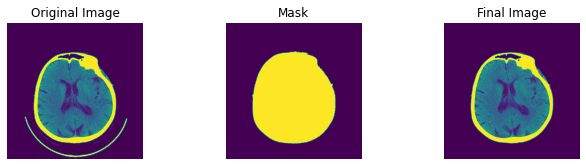

In [9]:
_ = remove_noise(file_path, display=True)

<ipython-input-8-ea0871e24ddf>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_count = np.bincount(labels.ravel().astype(np.int))


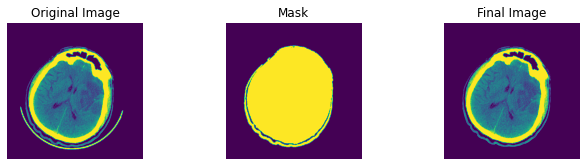

In [10]:
path2 = "/Users/esmasert/Desktop/TeknoFest/Veriler/TRAINING/ISKEMI/DICOM/10354.dcm"
_ = remove_noise(path2, display=True)

# Tilt Correction

<ipython-input-8-ea0871e24ddf>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_count = np.bincount(labels.ravel().astype(np.int))


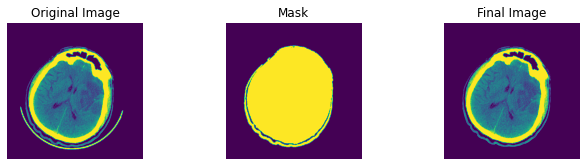

In [11]:
iskemiMaskedImg = remove_noise(path2, display=True)

In [12]:
import cv2
import numpy as np
import pydicom
from matplotlib import pyplot as plt
import numpy
import math
import pylab

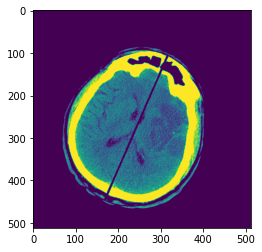

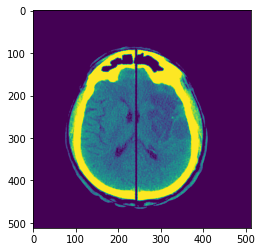

In [13]:
img=numpy.uint8 (iskemiMaskedImg)
contours, hier =cv2.findContours (img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask=numpy.zeros (img.shape, numpy.uint8)

# find the biggest contour (c) by the area
c = max(contours, key = cv2.contourArea)

(x,y),(MA,ma),angle = cv2.fitEllipse(c)

cv2.ellipse(img, ((x,y), (MA,ma), angle), color=(0, 255, 0), thickness=2)

rmajor = max(MA,ma)/2
if angle > 90:
    angle -= 90
else:
    angle += 96
xtop = x + math.cos(math.radians(angle))*rmajor
ytop = y + math.sin(math.radians(angle))*rmajor
xbot = x + math.cos(math.radians(angle+180))*rmajor
ybot = y + math.sin(math.radians(angle+180))*rmajor
cv2.line(img, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 255, 0), 3)

pylab.imshow(img)
pylab.show()

M = cv2.getRotationMatrix2D((x, y), angle-90, 1)  #transformation matrix

img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)

pylab.imshow(img)
pylab.show()


# Centering The Image and Adding Pads

In [14]:
def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0

    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]
    
    return croped_image

In [15]:
croppedImage = crop_image(img)

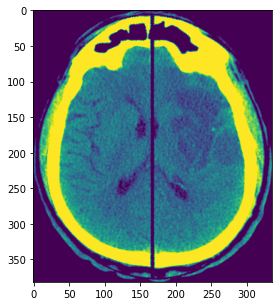

In [16]:
plt.figure(figsize=(15, 5))
plt.imshow(croppedImage)

In [17]:
croppedImage.shape

(382, 335)

In [18]:
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) // 2)
    pad_top = int((new_height - height) // 2)
    
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

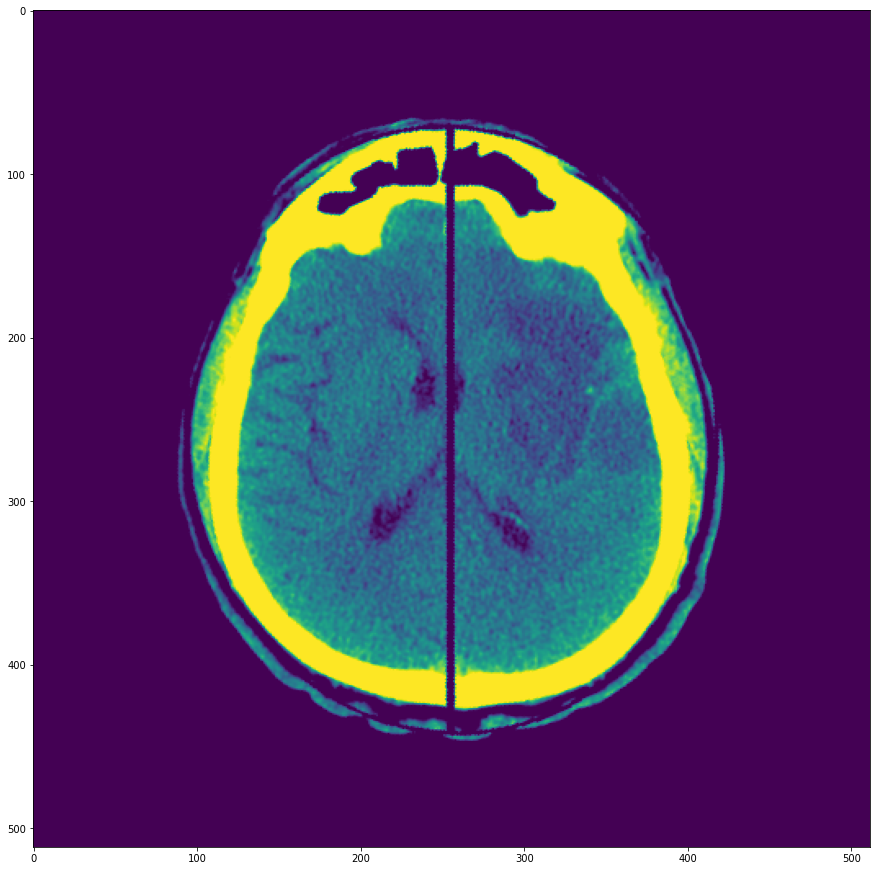

In [19]:
plt.figure(figsize=(15, 25))
final_image = add_pad(croppedImage)
plt.imshow(final_image)

In [20]:
new_name = "new_MR_2.png"
folder_name = "/Users/esmasert/Desktop/centered/"
cv2.imwrite(os.path.join(folder_name,new_name),final_image*3)

True

# Applying to All Kanama Images

In [21]:
import pydicom as di 
import os
from os import listdir

In [22]:
dicomFilesKanama = "/Users/esmasert/Desktop/TeknoFest/Veriler/TrainingDicom/KANAMA/"

In [23]:
DCMFiles = [] 
for dirName, subdirList, fileList in os.walk(dicomFilesKanama):
    for filename in fileList:
        if ".dcm" in filename.lower():
            DCMFiles.append(os.path.join(dirName,filename))
print("Number of (.dcm) files =", len(DCMFiles))

Number of (.dcm) files = 1093


In [24]:
DCMFiles

['/Users/esmasert/Desktop/TeknoFest/Veriler/TrainingDicom/KANAMA/14126.dcm',
 '/Users/esmasert/Desktop/TeknoFest/Veriler/TrainingDicom/KANAMA/12231.dcm',
 '/Users/esmasert/Desktop/TeknoFest/Veriler/TrainingDicom/KANAMA/13885.dcm',
 '/Users/esmasert/Desktop/TeknoFest/Veriler/TrainingDicom/KANAMA/13675.dcm',
 '/Users/esmasert/Desktop/TeknoFest/Veriler/TrainingDicom/KANAMA/11704.dcm',
 '/Users/esmasert/Desktop/TeknoFest/Veriler/TrainingDicom/KANAMA/14668.dcm',
 '/Users/esmasert/Desktop/TeknoFest/Veriler/TrainingDicom/KANAMA/16094.dcm',
 '/Users/esmasert/Desktop/TeknoFest/Veriler/TrainingDicom/KANAMA/16080.dcm',
 '/Users/esmasert/Desktop/TeknoFest/Veriler/TrainingDicom/KANAMA/10397.dcm',
 '/Users/esmasert/Desktop/TeknoFest/Veriler/TrainingDicom/KANAMA/16916.dcm',
 '/Users/esmasert/Desktop/TeknoFest/Veriler/TrainingDicom/KANAMA/12033.dcm',
 '/Users/esmasert/Desktop/TeknoFest/Veriler/TrainingDicom/KANAMA/12755.dcm',
 '/Users/esmasert/Desktop/TeknoFest/Veriler/TrainingDicom/KANAMA/14330.dcm',

In [25]:
def tiltCorrection(maskedImage):
    
    img=numpy.uint8 (maskedImage)
    contours, hier =cv2.findContours (img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask=numpy.zeros (img.shape, numpy.uint8)

    # find the biggest contour (c) by the area
    c = max(contours, key = cv2.contourArea)

    (x,y),(MA,ma),angle = cv2.fitEllipse(c)

    cv2.ellipse(img, ((x,y), (MA,ma), angle), color=(0, 255, 0), thickness=2)

    rmajor = max(MA,ma)/2
    if angle > 90:
        angle -= 90
    else:
        angle += 96
    xtop = x + math.cos(math.radians(angle))*rmajor
    ytop = y + math.sin(math.radians(angle))*rmajor
    xbot = x + math.cos(math.radians(angle+180))*rmajor
    ybot = y + math.sin(math.radians(angle+180))*rmajor
    cv2.line(img, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 255, 0), 3)

    M = cv2.getRotationMatrix2D((x, y), angle-90, 1)  #transformation matrix

    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)

    return img

In [26]:
x=0

for dicomFile in DCMFiles:
    
    temp = dicomFile.split('/')
    temp = temp[-1].split('.')
    new_name = temp[-2] + ".png"
    folder_name = "/Users/esmasert/Desktop/centered/"
    
    print(new_name)
    
    maskedImage = remove_noise(dicomFile, display=False)
    tiltCorrectedImage = tiltCorrection(maskedImage)
    croppedImage = crop_image(tiltCorrectedImage)
    final_image = add_pad(croppedImage)
    
    
    cv2.imwrite(os.path.join(folder_name,new_name),final_image*3)
    
    x+=1
    
    print("***"+str(x)+"***")
    

    

14126.png
***1***
12231.png


/Users/esmasert/opt/anaconda3/lib/python3.8/site-packages/openjpeg/utils.py:198: UserWarning: The (0028,0101) Bits Stored value '12' in the dataset does not match the component precision value '16' found in the JPEG 2000 data. It's recommended that you change the Bits Stored value to produce the correct output
  warnings.warn(
<ipython-input-8-ea0871e24ddf>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_count = np.bincount(labels.ravel().astype(np.int))


***2***
13885.png
***3***
13675.png
***4***
11704.png
***5***
14668.png
***6***
16094.png
***7***
16080.png
***8***
10397.png
***9***
16916.png
***10***
12033.png
***11***
12755.png
***12***
14330.png
***13***
11248.png
***14***
16527.png
***15***
10156.png
***16***
11506.png
***17***
13311.png
***18***
15006.png
***19***
12796.png
***20***
15953.png
***21***
14536.png
***22***
10036.png
***23***
16453.png
***24***
12609.png
***25***
10793.png
***26***
16484.png
***27***
14287.png
***28***
10787.png
***29***
12423.png
***30***
10234.png
***31***
12351.png
***32***
16889.png
***33***
16679.png
***34***
14708.png
***35***
13067.png
***36***
13932.png
***37***
16862.png
***38***
14907.png
***39***
13099.png
***40***
13714.png
***41***
11117.png
***42***
11671.png
***43***
13066.png
***44***
11659.png
***45***
10547.png
***46***
16644.png
***47***
12422.png
***48***
14053.png
***49***
15198.png
***50***
11498.png
***51***
10786.png
***52***
15826.png
***53***
11301.png
***54***
17016.png
*

/Users/esmasert/opt/anaconda3/lib/python3.8/site-packages/openjpeg/utils.py:198: UserWarning: The (0028,0101) Bits Stored value '13' in the dataset does not match the component precision value '16' found in the JPEG 2000 data. It's recommended that you change the Bits Stored value to produce the correct output
  warnings.warn(


***58***
12152.png
***59***
10745.png
***60***
12146.png


ValueError: could not broadcast input array from shape (535,463) into shape (12,463)